# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [54]:
import pandas as pd
import numpy as np

In [55]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [56]:
output_dir

'/Users/jamessiegener/MSDS/DS5001/output'

In [57]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]

In [58]:
widx

['w0', 'w1', 'w2']

# Get Some Training Data

In [59]:
data_dir = output_dir
OHCO = ['book_id','chap_num','para_num','sent_num','token_num']

In [60]:
TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
TOKEN['term_str'] = TOKEN.token_str.replace(r'[\W_]+', '', regex=True).str.lower()
VOCAB = TOKEN.term_str.value_counts().to_frame('n').reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [61]:
TOKEN.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0               Sir       sir
                                   1            Walter    walter
                                   2            Elliot    elliot
                                   3                of        of
                                   4          Kellynch  kellynch

In [62]:
VOCAB.head()

,term_str,n
term_id,,
0,the,7435
1,to,6923
2,and,6290
3,of,6146
4,her,3747


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [95]:
VOCAB['n_chars'] = VOCAB.term_str.str.len()
VOCAB['modified_term_str'] = VOCAB.index.astype(str)
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

In [96]:
VOCAB

,term_str,n,n_chars,modified_term_str
term_id,,,,
0,the,7435,3,0
1,to,6923,2,1
2,and,6290,3,2
3,of,6146,2,3
4,her,3747,3,4
...,...,...,...,...
8233,inhumanity,1,10,8233
8234,flagrant,1,8,8234
8235,grievances,1,10,8235


We apply the modified term list to our tokens.

In [97]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [98]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

ValueError: a must be greater than 0 unless no samples are taken

# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

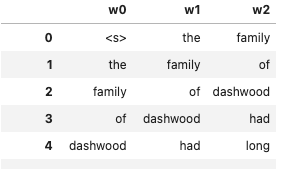

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number.

We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph.

We want the order of the sentence within the corpus.

In [ ]:
def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    padded.index.names = ohco
    return padded

In [ ]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:4], term_str='modified_term_str')

In [ ]:
PADDED.head()

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [ ]:
# T = PADDED.groupby(OHCO[:4]).apply(lambda x: pd.concat([x.shift(0-i) for i in range(ngrams)], axis=1)).reset_index(drop=True)
# T.index = PADDED.index
# T.columns = widx

In [ ]:
# T.loc[(1,1,0,2)]

In [ ]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper)\
        .apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1))\
        .reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [ ]:
NGRAMS = padded_to_ngrams(PADDED, OHCO[:4], ngrams)

In [64]:
NGRAMS

NameError: name 'NGRAMS' is not defined

## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [65]:
def ngrams_to_models(ngrams):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [66]:
M = ngrams_to_models(NGRAMS)

NameError: name 'NGRAMS' is not defined

In [67]:
M[2]

NameError: name 'M' is not defined

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [68]:
def sentence_to_token(sent_list, file=True):
    
    # Convert list of sentences to dataframe
    if file:
        S = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
    else:
        S = pd.DataFrame(sent_list, columns=['sent_str'])
    S.index.name = 'sent_num'
    
    # Convert dataframe of sentences to TOKEN with normalized terms
    K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
    K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
    K.index.names = ['sent_num', 'token_num']
    
    return S, K

In [69]:
TEST_SENTS, TEST_TOKENS = sentence_to_token("test_sentences.txt")

In [70]:
TEST_SENTS.head()

,sent_str
sent_num,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,ChatGPT is not the singularity
4,but it was a black morning's work for her


In [71]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               the      the
         1             quick    quick
         2             brown    brown
         3               fox      fox
         4            jumped   jumped

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [72]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"

NameError: name 'M' is not defined

In [73]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

Series([], Name: count, dtype: int64)

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [74]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

NameError: name 'token_to_padded' is not defined

In [75]:
TEST_PADDED.head()

NameError: name 'TEST_PADDED' is not defined

In [76]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', ngrams)

NameError: name 'TEST_PADDED' is not defined

In [77]:
TEST_NGRAMS.loc[0]

NameError: name 'TEST_NGRAMS' is not defined

## Bind the models to test data

We add our model data to the test data as a set of features.

In [78]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(ohco + widx).i #.to_frame(f"i{i}")
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [79]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

NameError: name 'M' is not defined

In [80]:
def compute_perplexity(results, test_sents, n=3):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [81]:
PP = compute_perplexity(R, TEST_SENTS)

NameError: name 'R' is not defined

In [82]:
PP

NameError: name 'PP' is not defined

In [83]:
# T0 = TEST_NGRAMS.merge(M[0], on=['w0'], how='left')
# T0.index = TEST_NGRAMS.index
# TEST_SENTS['pp0'] = np.exp2(T0.groupby('sent_num').i.mean())

# T1 = TEST_NGRAMS.merge(M[1], on=['w0','w1'], how='left')
# T1.index = TEST_NGRAMS.index
# TEST_SENTS['pp1']= np.exp2(T1.groupby('sent_num').ci.mean())

# T2 = TEST_NGRAMS.merge(M[2], on=['w0','w1','w2'], how='left')
# T2.index = TEST_NGRAMS.index
# TEST_SENTS['pp2']= np.exp2(T2.groupby('sent_num').ci.mean())

# Model Perplexity

In [84]:
# R.groupby('sent_num').mean().mean().plot.bar();

In [85]:
np.exp2(R.mean()).plot.bar(rot=0);

NameError: name 'R' is not defined

In [86]:
PP.iloc[:,1:].corr().style.background_gradient(axis=None)

NameError: name 'PP' is not defined

In [87]:
# PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("level_0 < level_1").set_index(['level_0','level_1'])

# Visualize

In [88]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [89]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

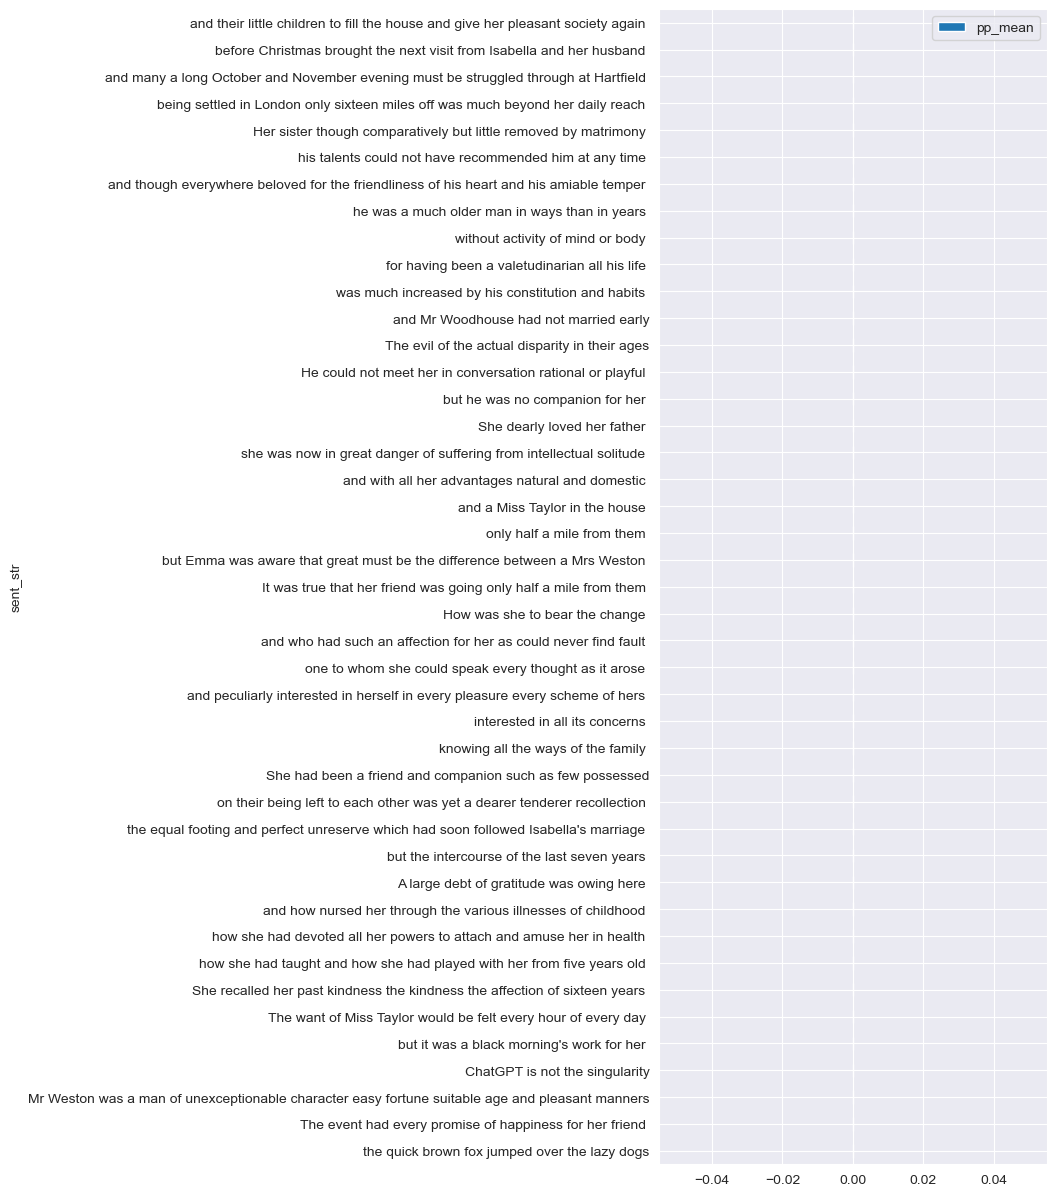

In [90]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

# Generate Text

In [91]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','')\
        .strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [92]:
generate_text(M)

NameError: name 'M' is not defined